Download audio from youtube

In [259]:
import youtube_dl
import urllib.request
import urllib.parse
import re
import os
import seaborn as sns
import numpy as np
from pandas import DataFrame as df
from sklearn.preprocessing import StandardScaler
from scipy.io import wavfile
from scipy import signal
from scipy.ndimage.interpolation import shift
from scipy.io.wavfile import write
import librosa, librosa.display
import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
def get_video(url, duration=None):
    options = {
        'format': 'bestaudio/best',
        'extractaudio': True,
        'audioformat': 'wav',
        'noplaylist': True,
        'outtmpl': '%(id)s',
    }

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192'
        }],
        'postprocessor_args': [
            '-ar', '16000'
        ],
        'prefer_ffmpeg': True,
        'keepvideo': False
    }
    
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=True)
        title = result['title']+"-"+result['id']+".wav"
        return title

In [5]:
def load_song(title):
    return librosa.load(title)

In [6]:
def search_youtube(query):
    query_string = urllib.parse.urlencode({"search_query" : query})
    html_content = urllib.request.urlopen("http://www.youtube.com/results?" + query_string)
    search_results = re.findall(r'href=\"\/watch\?v=(.{11})', html_content.read().decode())
    return "http://www.youtube.com/watch?v=" + search_results[0]

In [7]:
def get_spectrogram(x, sr):
    hop_length = 256
    n_fft = 2048
    X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

    S = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')

In [8]:
def make_same_size(S, S2):
    shape_1 = len(S)
    shape_2 = len(S2)
    song_1 = []
    song_2 = []
    diff = 0
    def pad(larger, smaller):
        diff = len(larger) - len(smaller)
        smaller = np.append(smaller, np.zeros(diff))
        return larger, smaller
        
    if shape_1 > shape_2:
        song_1, song_2 = pad(S, S2)
    else:
        song_2, song_1 = pad(S2, S)
    return song_1, song_2

In [9]:
def get_match(S, S2):
    size = len(S2)
    diffs = []
    start_index = 0
    window_size = 10000
    window = S2[start_index:start_index+window_size]
    max_diff = abs(len(S) - len(S2))
    
    zeros = np.zeros(max_diff)
    if len(S) > len(S2):
        S2 = np.append(S2, zeros)
    else:
        S = np.append(S, zeros)
    
    for i in range(0, max_diff):
        diffs.append(np.linalg.norm(window-S[i:i+window_size]))
        
    index = diffs.index(min(diffs))
    shift_by = index - start_index
    print(shift_by)
    S2 = shift(S2, shift_by, cval=0)
    return S, S2

In [10]:
def get_stft(song):
    hop_length = 512
    n_fft = 2048
    return librosa.stft(song, n_fft=n_fft, hop_length=hop_length)

In [42]:
search_term = 'ariana grande one more time'
song_url = search_youtube(search_term)
acapella_url = search_youtube(search_term+' acapella')
song_title = get_video(song_url)
acapella_title = get_video(acapella_url)

[youtube] Wg92RrNhB8s: Downloading webpage
[youtube] Wg92RrNhB8s: Downloading video info webpage
[download] Destination: Ariana Grande - One Last Time (Lyric Video)-Wg92RrNhB8s.webm
[download] 100% of 3.15MiB in 00:00                  
[ffmpeg] Destination: Ariana Grande - One Last Time (Lyric Video)-Wg92RrNhB8s.wav
Deleting original file Ariana Grande - One Last Time (Lyric Video)-Wg92RrNhB8s.webm (pass -k to keep)
[youtube] J3bFaa9g-x0: Downloading webpage
[youtube] J3bFaa9g-x0: Downloading video info webpage
[download] Destination: Ariana Grande - One Last Time - Acapella Version-J3bFaa9g-x0.webm
[download] 100% of 3.38MiB in 00:00                  
[ffmpeg] Destination: Ariana Grande - One Last Time - Acapella Version-J3bFaa9g-x0.wav
Deleting original file Ariana Grande - One Last Time - Acapella Version-J3bFaa9g-x0.webm (pass -k to keep)


In [43]:
song, song_sample_rate = load_song(song_title)
acapella, acapella_sample_rate = load_song(acapella_title)

In [44]:
S, A = get_match(song, acapella)

0


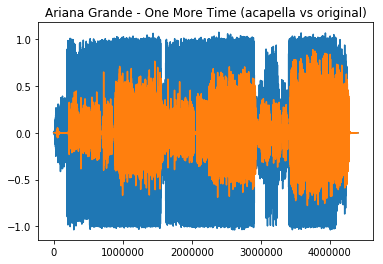

In [45]:
plt.title('Ariana Grande - One More Time (acapella vs original)')
plt.plot(S)
plt.plot(A)
plt.show()

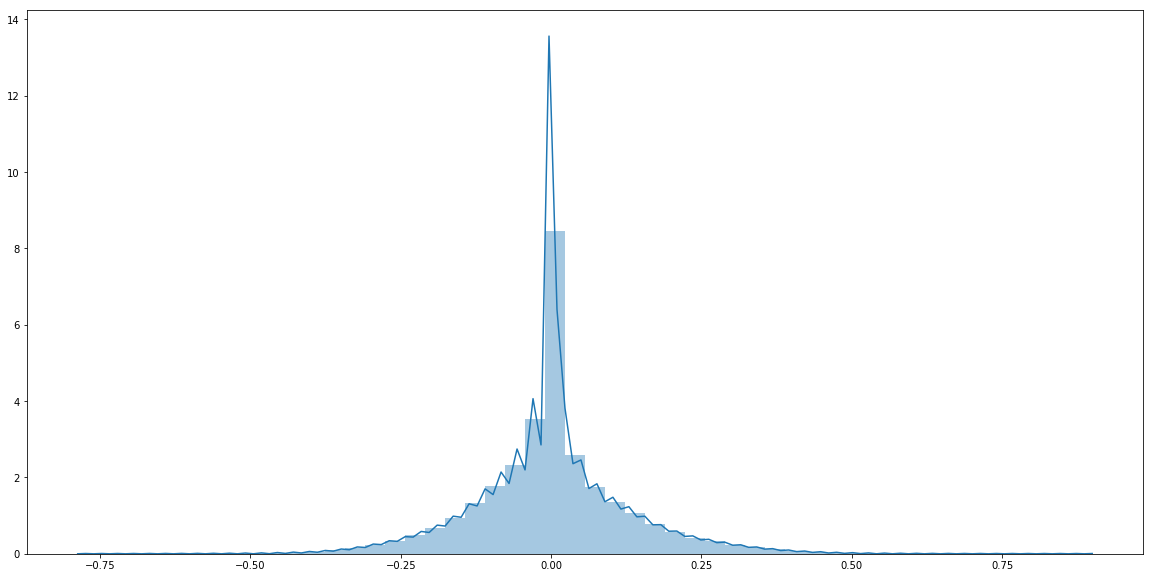

In [252]:
plt.title('Acapella Amplitude Distribution')
sns.distplot(A)
plt.show()

plt.title('Song Amplitude Distribution')
sns.distplot(S)
plt.show()
display(df(A).describe())

In [50]:
S_stft = get_stft(S)
A_stft = get_stft(A)

C:\Users\kalie\Anaconda3\lib\site-packages\librosa\display.py:696: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


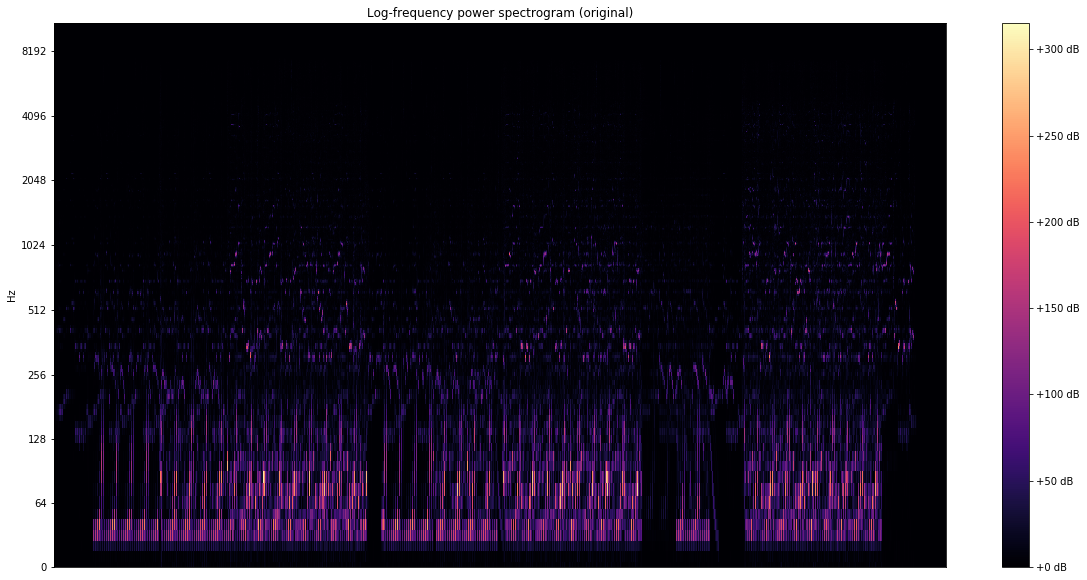

In [76]:
librosa.display.specshow(S_stft, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (original)')
plt.show()

C:\Users\kalie\Anaconda3\lib\site-packages\librosa\display.py:696: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


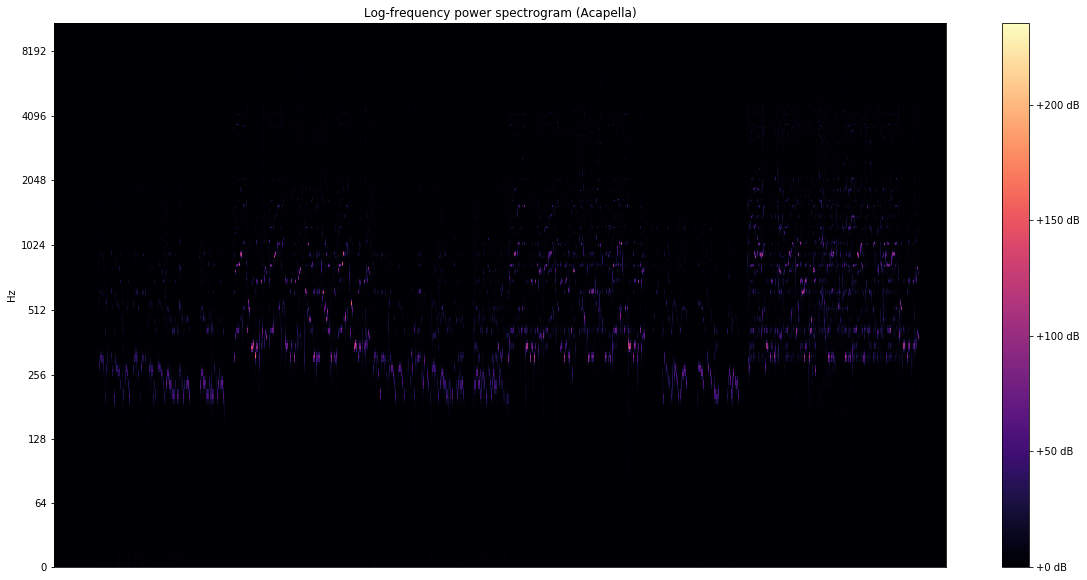

In [75]:
librosa.display.specshow(A_stft, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (Acapella)')
plt.show()

In [77]:
A_stft.shape

(1025, 8609)

In [54]:
S_stft.shape

(1025, 8609)

In [243]:
A_stft = np.abs(A_stft)
S_stft = np.abs(S_stft)
display(df(A_stft.flatten(), columns=['Vocals']).describe())
display(df(S_stft.flatten(), columns=['Song']).describe())

,Vocals
count,8.824225e+06
mean,7.521635e-01
std,3.282482e+00
min,0.000000e+00
25%,9.729179e-02
50%,2.310115e-01
75%,4.947144e-01
max,2.352003e+02


,Song
count,8.824225e+06
mean,1.976684e+00
std,8.166475e+00
min,0.000000e+00
25%,3.401344e-06
50%,2.960534e-01
75%,1.343858e+00
max,3.152310e+02


In [280]:
def shape_training_data(A, S, window_shape=(25,513)):
    X = []
    Y = []
    for i in range(0, A.shape[0]-window_shape[0]):
        middle = i+window_shape[0]//2
        X.append(np.array(A[i:window_shape[0]+i, 0:window_shape[1]]))
        Y.append(np.array(S[middle, 0:window_shape[1]]))
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1], 1))
    Y = Y.reshape((Y.shape[0], Y.shape[1]))
    return np.asarray(X), np.asarray(Y)

In [263]:
Transformer_X = StandardScaler().fit(S_stft)
Transformer_Y = StandardScaler().fit(A_stft)

In [264]:
X, Y = shape_training_data(Transformer_X.transform(A_stft), Transformer_Y.transform(S_stft))
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (1000, 513, 25, 1)
Y shape: (1000, 513)


In [265]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(513, 25, 1)))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(513, activation='sigmoid'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=sgd, metrics=['accuracy'])

In [266]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 513, 25, 32)       320       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 513, 25, 32)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 513, 25, 16)       4624      
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 513, 25, 16)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 171, 8, 16)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 171, 8, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 171, 8, 64)        9280      
__________

In [267]:
model.fit(X, Y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1000/1000 [==============================] - 39s 39ms/step - loss: 156730378.7623 - acc: 0.0010
Epoch 2/100
1000/1000 [==============================] - 38s 38ms/step - loss: 144391024.4871 - acc: 0.0011
Epoch 3/100
1000/1000 [==============================] - 38s 38ms/step - loss: 157956244.0306 - acc: 0.0011
Epoch 4/100
1000/1000 [==============================] - 37s 37ms/step - loss: 157824110.5457 - acc: 0.0011
Epoch 5/100
1000/1000 [==============================] - 37s 37ms/step - loss: 152297651.8481 - acc: 0.0011
Epoch 6/100
1000/1000 [==============================] - 39s 39ms/step - loss: 155839896.6425 - acc: 0.0011
Epoch 7/100
1000/1000 [==============================] - 40s 40ms/step - loss: 155567615.9653 - acc: 0.0010
Epoch 8/100
1000/1000 [==============================] - 40s 40ms/step - loss: 155698887.4474 - acc: 0.0011
Epoch 9/100
1000/1000 [==============================] - 42s 42ms/step - loss: 157050755.9316 - acc: 0.0011
Epoch 10/100
1000/1000 [====

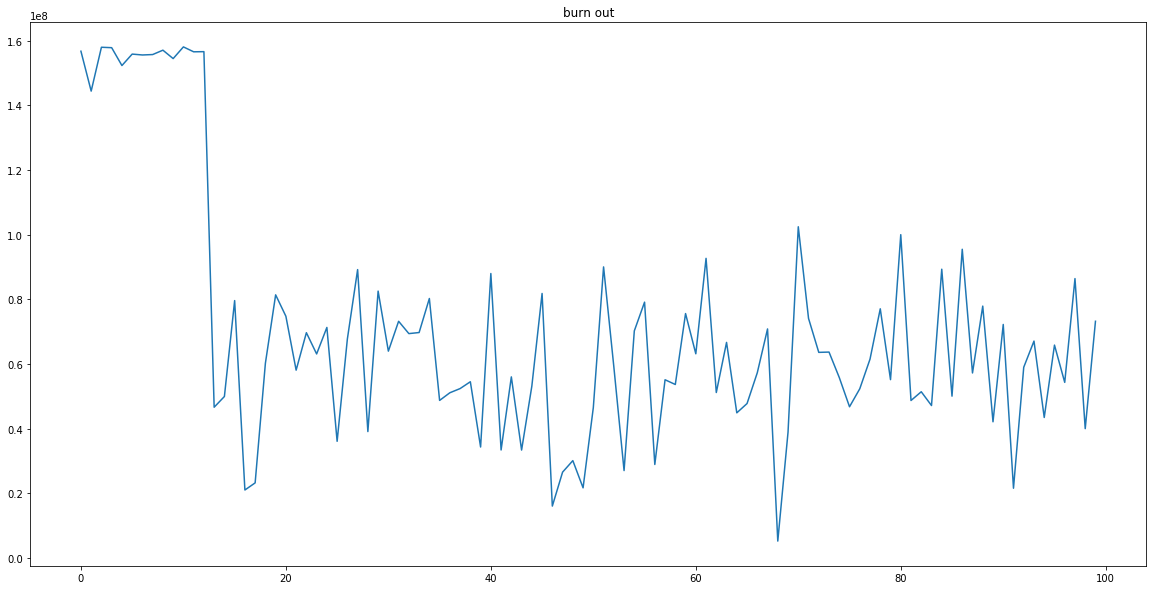

5.198259e+06


In [268]:
plt.plot(model.history.history['loss'])
plt.title('burn out')
plt.show()
print('%e' % np.min(model.history.history['loss']))

In [271]:
X_val = model.predict(X)

In [279]:
X_val.shape

(1000, 513)

In [282]:
hop_length = 512
n_fft = 2048
librosa.stft(X_val, n_fft=n_fft, hop_length=hop_length)

ParameterError: Invalid shape for monophonic audio: ndim=2, shape=(1000, 513)

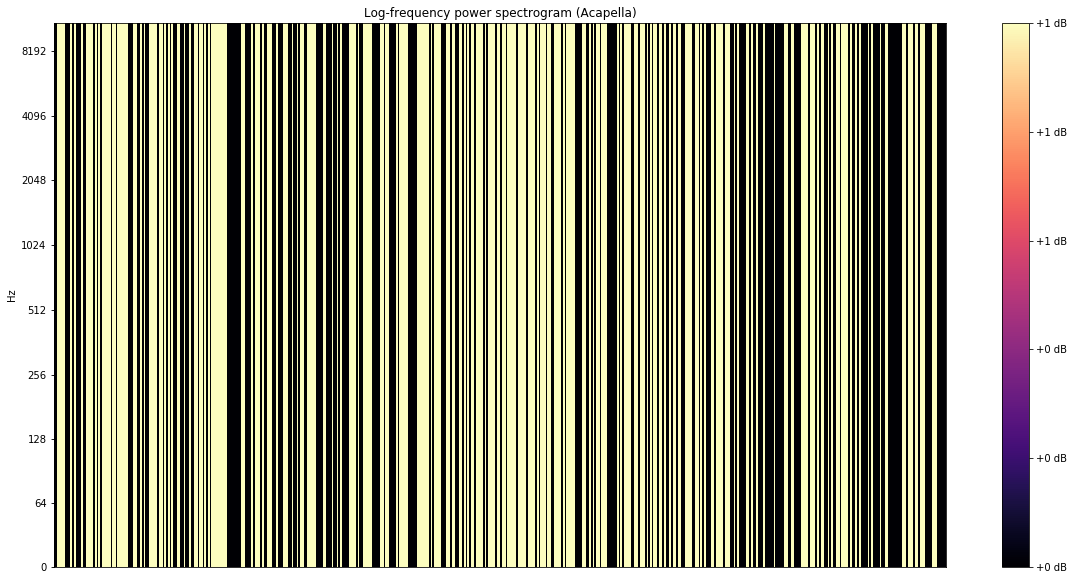

In [281]:
librosa.display.specshow(X_val, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (Acapella)')
plt.show()

In [316]:
buffer = 8609 - X_val.shape[1]
Y_v = np.empty(8609)
print(Y_v.shape)
for i in range(0, X_val.shape[0]):
    Y_v = np.vstack((Y_v,np.concatenate((X_val[i,:],np.zeros(buffer)))))
Y_v

(8609,)


array([[1.28612313e-311, 1.28638215e-311, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [317]:
Y_v.shape

(1001, 8609)

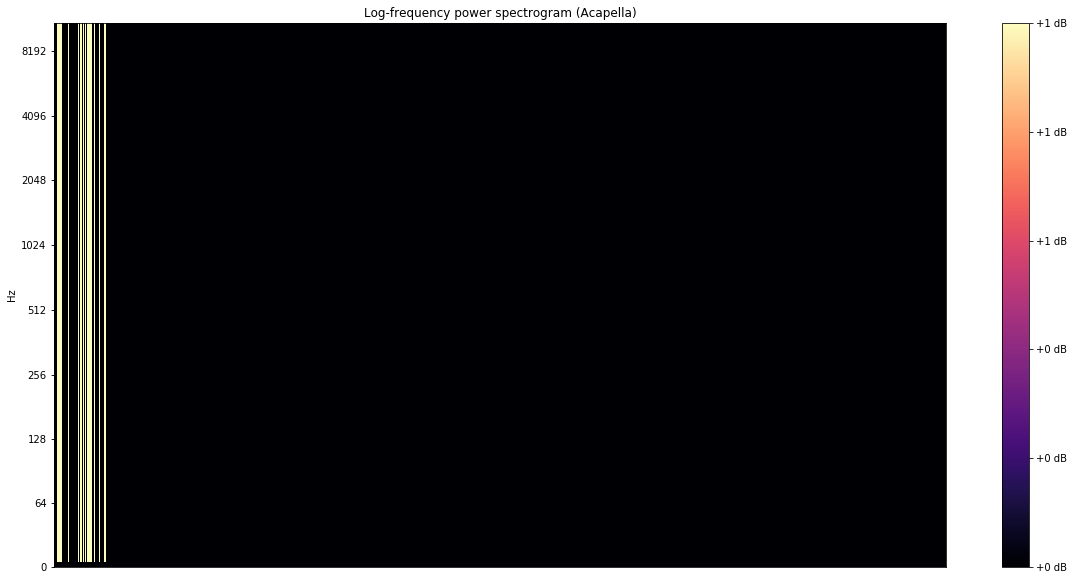

In [318]:
librosa.display.specshow(Y_v, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (Acapella)')
plt.show()

In [321]:
hop_length = 512
n_fft = 2048
val_song = librosa.istft(Y_v)

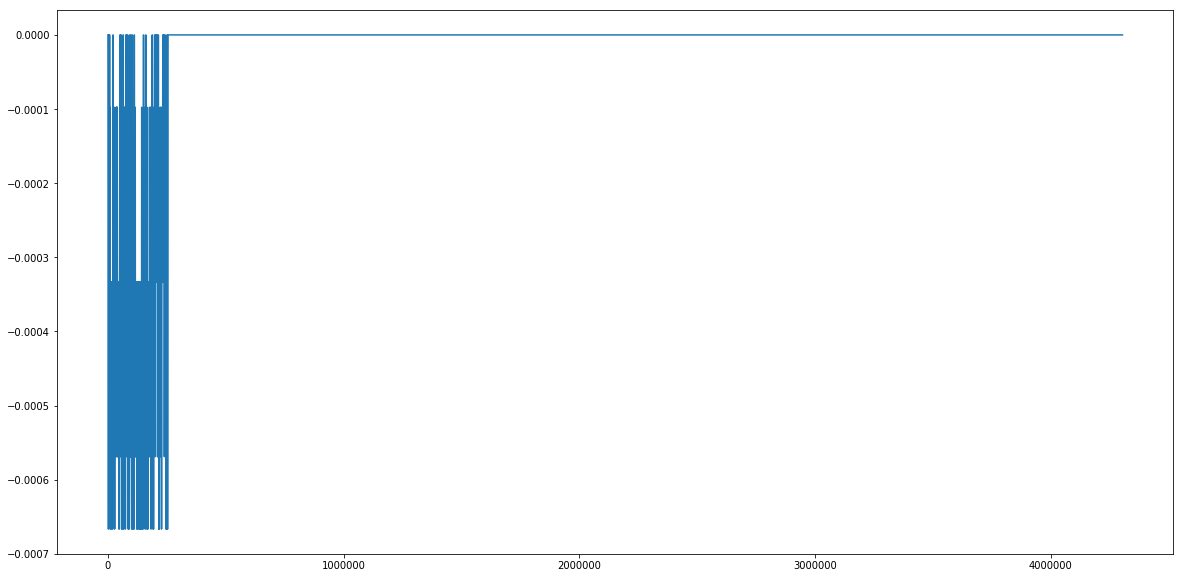

In [322]:
plt.plot(val_song)

In [324]:
fs = 44100
out_f = 'out.wav'

wavfile.write(out_f, fs, val_song)


# Next Steps:
- Debug the data processing here. Something is a bit off. At least verify that the data is preprocessed correctly
- 
### try to use Fréchet Inception Distance between spectrograms